In [35]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import urllib.request  # we import urllib to download lsun if needed
import zipfile  # we import zipfile to extract lsun archives
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os
sys.path.append('../../')
from typing import Tuple, Any

In [36]:
import interflow as itf
import interflow.stochastic_interpolant as stochastic_interpolant

In [37]:
RESULTS_ROOT = os.path.join("vresults", "cifarpatchedinterpolants")
DATASET_NAME = "cifar10_dog"
EPSILON_TAG = "eps-none"

In [38]:
if torch.cuda.is_available():
    print('cuda available, setting default tensor residence to gpu')
    itf.util.set_torch_device('cuda')
else:
    print('no cuda device found')
print(itf.util.get_torch_device())

cuda available, setting default tensor residence to gpu
cuda


In [39]:
print("torch version:", torch.__version__)

torch version: 2.9.0+cu128


In [40]:
# we define utility functions
def grab(var):
    """we take a tensor off the gpu and convert it to a numpy array on the cpu"""
    return var.detach().cpu().numpy()

In [41]:
def ensure_lsun_bedroom(lsun_root: str, max_retries: int = 3, timeout: int = 300) -> bool:
    """we download and extract lsun bedroom_train_lmdb if missing, returns True if successful"""  # we document lsun helper
    print(f"[verbose] ensure_lsun_bedroom called with lsun_root={lsun_root}")  # we log function call
    lsun_root_abs = os.path.abspath(lsun_root)  # we get absolute path
    print(f"[verbose] absolute lsun_root path: {lsun_root_abs}")  # we log absolute path
    bedroom_lmdb_dir = os.path.join(lsun_root, "bedroom_train_lmdb")  # we build expected lmdb directory
    bedroom_lmdb_dir_abs = os.path.abspath(bedroom_lmdb_dir)  # we get absolute path
    print(f"[verbose] checking for existing bedroom_train_lmdb at: {bedroom_lmdb_dir_abs}")  # we log check
    if os.path.isdir(bedroom_lmdb_dir):  # we check if directory already exists
        print(f"[verbose] ✓ found existing lsun bedroom_train_lmdb at {bedroom_lmdb_dir_abs}")  # we log existing dataset
        print(f"[verbose] directory contents: {os.listdir(bedroom_lmdb_dir_abs)[:5] if os.path.exists(bedroom_lmdb_dir_abs) else 'N/A'}")  # we log sample contents
        return True  # we return success
    
    print(f"[verbose] bedroom_train_lmdb directory not found, will attempt download")  # we log missing directory
    print(f"[verbose] creating lsun_root directory: {lsun_root_abs}")  # we log directory creation
    os.makedirs(lsun_root, exist_ok=True)  # we ensure root directory exists
    print(f"[verbose] ✓ lsun_root directory exists: {os.path.exists(lsun_root_abs)}")  # we verify creation
    url = "https://dl.yf.io/lsun/scenes/bedroom_train_lmdb.zip"  # we set official lsun download url
    zip_path = os.path.join(lsun_root, "bedroom_train_lmdb.zip")  # we choose local zip path
    zip_path_abs = os.path.abspath(zip_path)  # we get absolute path
    print(f"[verbose] download url: {url}")  # we log url
    print(f"[verbose] zip output path: {zip_path_abs}")  # we log zip path
    
    # we check if zip file already exists from previous incomplete download
    print(f"[verbose] checking for existing zip file at: {zip_path_abs}")  # we log zip check
    if os.path.exists(zip_path):  # we check for existing zip
        zip_size = os.path.getsize(zip_path) / (1024**3)  # we get file size in GB
        print(f"[verbose] ✓ found existing zip file at {zip_path_abs}, size: {zip_size:.2f} GB")  # we log existing zip
        print(f"[verbose] attempting to extract existing zip file...")  # we log extraction attempt
        try:  # we try to extract existing zip
            print(f"[verbose] opening zip file for integrity check...")  # we log zip open
            with zipfile.ZipFile(zip_path, "r") as zf:  # we open zip file
                print(f"[verbose] testing zip file integrity...")  # we log integrity test
                zf.testzip()  # we verify zip integrity
                print(f"[verbose] ✓ zip file is valid, extracting to {lsun_root_abs}...")  # we log validity
                zf.extractall(lsun_root)  # we extract all contents into root
                print(f"[verbose] extraction completed, verifying output...")  # we log verification
            if os.path.isdir(bedroom_lmdb_dir):  # we check extraction success
                print(f"[verbose] ✓ extraction successful, bedroom_train_lmdb directory created")  # we log success
                os.remove(zip_path)  # we remove zip after successful extraction
                print(f"[verbose] removed zip file {zip_path_abs}")  # we log removal
                print(f"[verbose] lsun bedroom_train_lmdb ready at {bedroom_lmdb_dir_abs}")  # we log success
                return True  # we return success
            else:  # extraction failed to create directory
                print(f"[verbose] ✗ extraction did not create bedroom_train_lmdb directory")  # we log failure
        except Exception as e:  # we catch extraction errors
            import traceback  # we import traceback for detailed error
            print(f"[verbose] ✗ error with existing zip file: {e}")  # we log error
            print(f"[verbose] full traceback:")  # we log traceback header
            traceback.print_exc()  # we print full traceback
            print(f"[verbose] removing corrupted zip file and will attempt re-download")  # we log removal
            os.remove(zip_path)  # we remove corrupted zip
    else:  # no existing zip
        print(f"[verbose] no existing zip file found")  # we log no zip
    
    # we attempt download with retries
    print(f"[verbose] starting download process")  # we log download start
    print(f"downloading lsun bedroom_train_lmdb from {url} ...")  # we log download start
    print(f"warning: this is a large file (~42GB), download may take a long time")  # we warn about size
    print(f"[verbose] using timeout={timeout}s per attempt, max_retries={max_retries}")  # we log retry settings
    
    for attempt in range(1, max_retries + 1):  # we attempt download multiple times
        print(f"[verbose] === download attempt {attempt}/{max_retries} ===")  # we log attempt start
        try:  # we wrap download in try-except
            print(f"[verbose] creating url request...")  # we log request creation
            def show_progress(block_num, block_size, total_size):  # we define progress callback
                downloaded = block_num * block_size  # we compute downloaded bytes
                if total_size > 0:  # we check if size is known
                    percent = min(downloaded * 100.0 / total_size, 100.0)  # we compute percentage
                    print(f"\r[attempt {attempt}/{max_retries}] download progress: {percent:.1f}% ({downloaded / (1024**3):.2f} GB / {total_size / (1024**3):.2f} GB)", end="", flush=True)  # we print progress
                else:  # size unknown
                    print(f"\r[attempt {attempt}/{max_retries}] downloaded: {downloaded / (1024**3):.2f} GB", end="", flush=True)  # we print progress without percentage
            
            # we create request with timeout
            request = urllib.request.Request(url)  # we create request
            print(f"[verbose] opening url connection with timeout={timeout}s...")  # we log connection attempt
            with urllib.request.urlopen(request, timeout=timeout) as response:  # we open connection with timeout
                print(f"[verbose] ✓ connection established, status: {response.getcode()}")  # we log connection success
                response_headers = dict(response.headers)  # we get response headers
                print(f"[verbose] response headers: {list(response_headers.keys())}")  # we log header keys
                total_size = int(response.headers.get("Content-Length", 0))  # we get total size from headers
                if total_size > 0:  # we check if size known
                    print(f"[verbose] total file size: {total_size / (1024**3):.2f} GB")  # we log file size
                else:  # size unknown
                    print(f"[verbose] warning: content-length not provided, cannot show percentage")  # we warn about unknown size
                print(f"[verbose] opening output file: {zip_path_abs}")  # we log file open
                with open(zip_path, "wb") as f:  # we open output file
                    downloaded = 0  # we initialize downloaded counter
                    block_size = 8192  # we set block size for reading
                    chunk_count = 0  # we initialize chunk counter
                    print(f"[verbose] starting to read data in {block_size} byte chunks...")  # we log read start
                    while True:  # we read in chunks
                        chunk = response.read(block_size)  # we read chunk
                        if not chunk:  # we check if done
                            print(f"[verbose] reached end of stream after {chunk_count} chunks")  # we log completion
                            break  # we exit loop
                        f.write(chunk)  # we write chunk
                        downloaded += len(chunk)  # we update downloaded counter
                        chunk_count += 1  # we increment chunk counter
                        if chunk_count % 10000 == 0:  # we log every 10000 chunks to avoid spam
                            if total_size > 0:  # we show progress if size known
                                percent = min(downloaded * 100.0 / total_size, 100.0)  # we compute percentage
                                print(f"\r[attempt {attempt}/{max_retries}] download progress: {percent:.1f}% ({downloaded / (1024**3):.2f} GB / {total_size / (1024**3):.2f} GB) [chunks: {chunk_count}]", end="", flush=True)  # we print progress
                            else:  # size unknown
                                print(f"\r[attempt {attempt}/{max_retries}] downloaded: {downloaded / (1024**3):.2f} GB [chunks: {chunk_count}]", end="", flush=True)  # we print progress
                    if total_size > 0:  # we show final progress
                        percent = min(downloaded * 100.0 / total_size, 100.0)  # we compute final percentage
                        print(f"\r[attempt {attempt}/{max_retries}] download progress: {percent:.1f}% ({downloaded / (1024**3):.2f} GB / {total_size / (1024**3):.2f} GB) [chunks: {chunk_count}]")  # we print final progress
                    else:  # size unknown
                        print(f"\r[attempt {attempt}/{max_retries}] downloaded: {downloaded / (1024**3):.2f} GB [chunks: {chunk_count}]")  # we print final progress
            print(f"[verbose] ✓ download complete (attempt {attempt})!")  # we confirm download completion
            final_size = os.path.getsize(zip_path) / (1024**3)  # we get final file size
            print(f"[verbose] downloaded file size: {final_size:.2f} GB")  # we log final size
            break  # we exit retry loop on success
        except Exception as e:  # we catch download errors
            import traceback  # we import traceback for detailed error
            print(f"\n[verbose] ✗ error on attempt {attempt}/{max_retries}: {e}")  # we log error
            print(f"[verbose] error type: {type(e).__name__}")  # we log error type
            print(f"[verbose] full traceback:")  # we log traceback header
            traceback.print_exc()  # we print full traceback
            if os.path.exists(zip_path):  # we check if partial file exists
                partial_size = os.path.getsize(zip_path) / (1024**3)  # we get partial size
                print(f"[verbose] removing partial file ({partial_size:.2f} GB)...")  # we log removal
                os.remove(zip_path)  # we remove corrupted partial file
                print(f"[verbose] ✓ partial file removed")  # we confirm removal
            if attempt < max_retries:  # we check if more retries available
                print(f"[verbose] waiting 5 seconds before retry...")  # we log retry wait
                time.sleep(5)  # we wait before retry
            else:  # all retries exhausted
                print(f"[verbose] ✗ failed to download after {max_retries} attempts")  # we log final failure
                return False  # we return failure   
    
    # we verify zip file exists and is valid
    print(f"[verbose] verifying zip file exists...")  # we log verification
    if not os.path.exists(zip_path):  # we check zip existence
        print(f"[verbose] ✗ zip file not found at {zip_path_abs} after download attempts")  # we log error
        return False  # we return failure
    zip_size = os.path.getsize(zip_path) / (1024**3)  # we get zip size
    print(f"[verbose] ✓ zip file exists at {zip_path_abs}, size: {zip_size:.2f} GB")  # we log zip exists
    
    print(f"[verbose] extracting archive from {zip_path_abs} to {lsun_root_abs}...")  # we log extraction start
    try:  # we wrap extraction in try-except
        print(f"[verbose] opening zip file for extraction...")  # we log zip open
        with zipfile.ZipFile(zip_path, "r") as zf:  # we open zip file
            file_list = zf.namelist()  # we get file list
            print(f"[verbose] zip contains {len(file_list)} files/directories")  # we log file count
            if len(file_list) > 0:  # we check if files exist
                print(f"[verbose] sample files (first 5): {file_list[:5]}")  # we log sample files
            print(f"[verbose] extracting all files...")  # we log extraction start
            zf.extractall(lsun_root)  # we extract all contents into root
            print(f"[verbose] ✓ extraction completed")  # we confirm extraction
    except Exception as e:  # we catch extraction errors
        import traceback  # we import traceback for detailed error
        print(f"[verbose] ✗ error extracting zip file: {e}")  # we log error
        print(f"[verbose] error type: {type(e).__name__}")  # we log error type
        print(f"[verbose] full traceback:")  # we log traceback header
        traceback.print_exc()  # we print full traceback
        return False  # we return failure
    
    # we verify extraction succeeded
    print(f"[verbose] verifying extraction succeeded...")  # we log verification
    if not os.path.isdir(bedroom_lmdb_dir):  # we check if directory was created
        print(f"[verbose] ✗ extraction did not create expected directory {bedroom_lmdb_dir_abs}")  # we log error
        print(f"[verbose] contents of lsun_root: {os.listdir(lsun_root_abs) if os.path.exists(lsun_root_abs) else 'N/A'}")  # we log root contents
        return False  # we return failure
    print(f"[verbose] ✓ bedroom_train_lmdb directory created at {bedroom_lmdb_dir_abs}")  # we log success
    dir_contents = os.listdir(bedroom_lmdb_dir_abs)  # we get directory contents
    print(f"[verbose] directory contains {len(dir_contents)} items")  # we log item count
    if len(dir_contents) > 0:  # we check if items exist
        print(f"[verbose] sample contents (first 5): {dir_contents[:5]}")  # we log sample contents
    
    # we remove zip file after successful extraction
    print(f"[verbose] removing zip file after successful extraction...")  # we log removal start
    if os.path.exists(zip_path):  # we check zip still exists
        os.remove(zip_path)  # we remove zip file after extraction
        print(f"[verbose] ✓ removed zip file {zip_path_abs}")  # we log removal
    else:  # zip already removed
        print(f"[verbose] zip file already removed")  # we log already removed
    
    print(f"[verbose] ✓ lsun bedroom_train_lmdb ready at {bedroom_lmdb_dir_abs}")  # we log success
    return True  # we return success

In [42]:
# we load celebA dataset
print(f"[verbose] === starting dataset loading process ===")  # we log start
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # we resize celebA images to 32x32
    transforms.ToTensor(),  # we convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # we normalize channels
])

[verbose] === starting dataset loading process ===


In [43]:
max_samples = None  # we set max samples to None (use all), set to int to limit dataset size (e.g., 5000)
print(f"[verbose] max_samples: {max_samples}")  # we log max samples

[verbose] max_samples: None


In [44]:
# we load celebA dataset
celebA_root = "../../data/celeba"  # we set celebA root directory
print(f"[verbose] loading celebA dataset...")  # we log celebA load
print(f"[verbose] celebA root: {os.path.abspath(celebA_root)}")  # we log celebA root
print(f"[verbose] using transform: Resize(32x32) -> ToTensor -> Normalize")  # we log transform

[verbose] loading celebA dataset...
[verbose] celebA root: /home/janis/4A/probgraph/probgraph/data/celeba
[verbose] using transform: Resize(32x32) -> ToTensor -> Normalize


In [45]:
# we check if gdown is needed and try to install it
try:  # we try to import gdown
    import gdown  # we check if gdown is available
    print(f"[verbose] ✓ gdown is already installed")  # we log gdown available
except ImportError:  # gdown not installed
    print(f"[verbose] gdown not found, attempting to install...")  # we log installation attempt
    try:  # we try to install gdown
        import subprocess  # we import subprocess for pip install
        subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown", "--quiet"])  # we install gdown
        print(f"[verbose] ✓ gdown installed successfully")  # we log success
        import gdown  # we import gdown after installation
    except Exception as install_error:  # installation failed
        print(f"[verbose] ✗ failed to install gdown: {install_error}")  # we log installation failure
        print(f"[verbose] will skip celebA and use cifar10 directly")  # we log skip

[verbose] gdown not found, attempting to install...
[verbose] ✗ failed to install gdown: Command '['/home/janis/4A/probgraph/probgraph/.venv/bin/python', '-m', 'pip', 'install', 'gdown', '--quiet']' returned non-zero exit status 1.
[verbose] will skip celebA and use cifar10 directly


/home/janis/4A/probgraph/probgraph/.venv/bin/python: No module named pip


In [46]:
try:  # we wrap in try-except for error handling
    trainset = torchvision.datasets.CelebA(
        root=celebA_root,  # we set celebA root directory
        split="train",  # we use training split
        download=True,  # we allow automatic download
        transform=transform  # we apply preprocessing transforms
    )  # we load celebA
    print(f"[verbose] ✓ celebA loaded successfully")  # we log success
    print(f"\nloaded celebA train: {len(trainset)} images")  # we log celebA size
    if max_samples is not None:  # we check if limiting samples
        print(f"[verbose] limiting to first {max_samples} samples for faster training/testing...")  # we log limitation
        trainset = torch.utils.data.Subset(trainset, list(range(min(max_samples, len(trainset)))))  # we limit subset
        print(f"[verbose] ✓ limited trainset size: {len(trainset)} images")  # we log limited size
        print(f"using subset of {len(trainset)} images")  # we log final size
except Exception as e:  # we catch loading errors
    import traceback  # we import traceback for detailed error
    print(f"[verbose] ✗ error loading celebA: {e}")  # we log error
    print(f"[verbose] error type: {type(e).__name__}")  # we log error type
    print(f"[verbose] full traceback:")  # we log traceback header
    traceback.print_exc()  # we print full traceback
    print(f"\nwarning: celebA loading failed, falling back to cifar10 dog class")  # we warn about fallback
    # we fall back to cifar10
    print(f"[verbose] loading cifar10 dataset...")  # we log cifar10 load
    transform_cifar = transforms.Compose([
        transforms.ToTensor(),  # we convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # we normalize
    ])
    cifar10_root = "../../data/cifar10"  # we set cifar10 root
    print(f"[verbose] cifar10 root: {os.path.abspath(cifar10_root)}")  # we log cifar10 root
    try:  # we wrap cifar10 loading in try-except
        trainset_cifar = torchvision.datasets.CIFAR10(
            root=cifar10_root, train=True, download=True, transform=transform_cifar
        )  # we load cifar10
        print(f"[verbose] ✓ cifar10 loaded, total images: {len(trainset_cifar)}")  # we log cifar10 size
        target_class = 5  # we select dog class
        print(f"[verbose] filtering for class {target_class} (dog)...")  # we log filtering
        dog_indices = [i for i in range(len(trainset_cifar)) if trainset_cifar.targets[i] == target_class]  # we filter dog images
        print(f"[verbose] ✓ found {len(dog_indices)} dog images")  # we log dog count
        print(f"using cifar10 dog class: {len(dog_indices)} images")  # we log cifar10 size
        trainset = torch.utils.data.Subset(trainset_cifar, dog_indices)  # we create subset
        print(f"[verbose] created subset with {len(trainset)} images")  # we log subset size
        if max_samples is not None:  # we check if limiting samples
            print(f"[verbose] limiting to first {max_samples} samples...")  # we log limitation
            trainset = torch.utils.data.Subset(trainset, list(range(min(max_samples, len(trainset)))))  # we limit subset size
            print(f"[verbose] ✓ final trainset size: {len(trainset)} images")  # we log final size
    except Exception as cifar_error:  # we catch cifar10 loading errors
        import traceback  # we import traceback for detailed error
        print(f"[verbose] ✗ error loading cifar10: {cifar_error}")  # we log error
        print(f"[verbose] error type: {type(cifar_error).__name__}")  # we log error type
        print(f"[verbose] full traceback:")  # we log traceback header
        traceback.print_exc()  # we print full traceback
        print(f"\nerror: both celebA and cifar10 loading failed")  # we log final error
        print(f"please check your network connection or download datasets manually")  # we suggest manual download
        raise  # we re-raise exception to stop execution

[verbose] ✗ error loading celebA: To download files from GDrive, 'gdown' is required. You can install it with 'pip install gdown'.
[verbose] error type: RuntimeError
[verbose] full traceback:

[verbose] loading cifar10 dataset...
[verbose] cifar10 root: /home/janis/4A/probgraph/probgraph/data/cifar10


Traceback (most recent call last):
  File "/home/janis/4A/probgraph/probgraph/.venv/lib/python3.12/site-packages/torchvision/datasets/utils.py", line 187, in download_file_from_google_drive
    import gdown
ModuleNotFoundError: No module named 'gdown'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_267718/2460172790.py", line 2, in <module>
    trainset = torchvision.datasets.CelebA(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/janis/4A/probgraph/probgraph/.venv/lib/python3.12/site-packages/torchvision/datasets/celeba.py", line 85, in __init__
    self.download()
  File "/home/janis/4A/probgraph/probgraph/.venv/lib/python3.12/site-packages/torchvision/datasets/celeba.py", line 160, in download
    download_file_from_google_drive(file_id, os.path.join(self.root, self.base_folder), filename, md5)
  File "/home/janis/4A/probgraph/probgraph/.venv/lib/python3.12/site-packages/torchvision/datasets/ut

[verbose] ✓ cifar10 loaded, total images: 50000
[verbose] filtering for class 5 (dog)...
[verbose] ✓ found 5000 dog images
using cifar10 dog class: 5000 images
[verbose] created subset with 5000 images


In [47]:
# we create data iterator that only samples from dataset images
print(f"[verbose] === dataset loading complete ===")  # we log completion
print(f"[verbose] final trainset size: {len(trainset)} images")  # we log final size
print(f"[verbose] device: {itf.util.get_torch_device()}")  # we log device

[verbose] === dataset loading complete ===
[verbose] final trainset size: 5000 images
[verbose] device: cuda


In [48]:
def get_cifar_batch(bs):
    """we get a batch of dataset images"""
    indices = torch.randint(0, len(trainset), (bs,))  # we sample random indices
    imgs = torch.stack([trainset[i][0] for i in indices])  # we stack selected images
    return imgs.to(itf.util.get_torch_device())  # we move batch to device

In [49]:
# we create masking function for patches
def create_patch_mask(bs, patch_size=6, num_patches=4):
    """we create random patch masks, 1 for visible pixels, 0 for masked patches"""
    mask = torch.ones(bs, 3, 32, 32)
    for i in range(bs):
        for _ in range(num_patches):
            x = torch.randint(0, 32 - patch_size, (1,)).item()
            y = torch.randint(0, 32 - patch_size, (1,)).item()
            mask[i, :, x:x+patch_size, y:y+patch_size] = 0  # we mask the patch
    return mask.to(itf.util.get_torch_device())

In [50]:
class SinusoidalTimeEmbedding(nn.Module):
    """we build sinusoidal positional embeddings for scalar time"""  # we describe time embedding
    def __init__(self, embedding_dim: int, max_period: float = 10000.0) -> None:
        super().__init__()  # we call parent constructor
        self.embedding_dim = embedding_dim  # we store embedding dimension
        self.max_period = max_period  # we store maximum period
    
    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """we map scalar timesteps to sinusoidal embeddings"""  # we describe forward
        if not isinstance(t, torch.Tensor):  # we convert non-tensor to tensor
            t_tensor = torch.tensor(t, dtype=torch.float32)  # we build tensor from scalar or array
        else:
            t_tensor = t.float()  # we cast to float
        if t_tensor.dim() == 0:  # we handle scalar time
            t_tensor = t_tensor[None]  # we add batch dimension
        if t_tensor.dim() == 2 and t_tensor.shape[1] == 1:  # we squeeze singleton feature dimension
            t_tensor = t_tensor[:, 0]  # we reduce to shape [bs]
        device = t_tensor.device  # we get device
        half_dim = self.embedding_dim // 2  # we compute half dimension
        if half_dim < 1:  # we guard against invalid configuration
            raise ValueError("we expect embedding_dim to be at least 2")  # we raise error for tiny dims
        exponent = -torch.log(torch.tensor(self.max_period, device=device)) / float(half_dim - 1)  # we compute exponent
        freqs = torch.exp(torch.arange(half_dim, device=device, dtype=torch.float32) * exponent)  # we build frequencies
        args = t_tensor.view(-1, 1) * freqs.view(1, -1)  # we build outer product of time and frequencies
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # we concatenate sin and cos
        if self.embedding_dim % 2 == 1:  # we pad for odd dimension
            emb = torch.nn.functional.pad(emb, (0, 1))  # we add one zero dimension
        return emb  # we return embeddings

In [51]:
class TimeResBlock(nn.Module):
    """we define residual block modulated by time embedding"""  # we describe residual block
    def __init__(self, in_channels: int, out_channels: int, time_dim: int, stride: int = 1) -> None:
        super().__init__()  # we call parent constructor
        self.in_channels = in_channels  # we store input channels
        self.out_channels = out_channels  # we store output channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)  # we define first conv
        self.norm1 = nn.GroupNorm(8, out_channels)  # we define first group norm
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)  # we define second conv
        self.norm2 = nn.GroupNorm(8, out_channels)  # we define second group norm
        self.act = nn.ReLU()  # we define activation
        self.time_mlp = nn.Linear(time_dim, out_channels)  # we define linear layer for time embedding
        if stride != 1 or in_channels != out_channels:  # we check if skip connection must project
            self.skip = nn.Conv2d(in_channels, out_channels, 1, stride=stride)  # we define skip projection
        else:
            self.skip = nn.Identity()  # we define identity skip
    
    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        """we apply residual block given time embedding"""  # we describe forward
        h = self.conv1(x)  # we apply first convolution
        h = self.norm1(h)  # we normalize
        h = self.act(h)  # we activate
        time_out = self.time_mlp(t_emb).view(t_emb.shape[0], self.out_channels, 1, 1)  # we project time embedding
        h = h + time_out  # we inject time information
        h = self.conv2(h)  # we apply second convolution
        h = self.norm2(h)  # we normalize
        h = self.act(h)  # we activate
        return h + self.skip(x)  # we add residual connection

In [52]:
# we define u-net style convolutional denoiser for image reconstruction
class UNetDenoiser(nn.Module):
    """we use u-net architecture with time-conditioned residual blocks for image reconstruction"""  # we describe unet
    def __init__(self, in_channels: int = 3, out_channels: int = 3, base_channels: int = 64, time_dim: int = 256) -> None:
        super().__init__()  # we call parent constructor
        
        self.time_embedding = SinusoidalTimeEmbedding(time_dim)  # we build sinusoidal time encoder
        self.time_mlp = nn.Sequential(  # we refine time embedding
            nn.Linear(time_dim, time_dim),  # we apply linear projection
            nn.SiLU(),  # we apply nonlinearity
            nn.Linear(time_dim, time_dim),  # we apply second projection
        )  # we define time mlp
        
        # we define encoder (downsampling path) with time-conditioned residual blocks
        self.enc1 = TimeResBlock(in_channels, base_channels, time_dim, stride=1)  # we define first encoder block
        self.enc2 = TimeResBlock(base_channels, base_channels * 2, time_dim, stride=2)  # we define second encoder block
        self.enc3 = TimeResBlock(base_channels * 2, base_channels * 4, time_dim, stride=2)  # we define third encoder block
        
        # we define bottleneck
        self.bottleneck = TimeResBlock(base_channels * 4, base_channels * 8, time_dim, stride=2)  # we define bottleneck block
        
        # we define decoder (upsampling path) with skip connections and time-conditioned residual blocks
        self.dec3_up = nn.ConvTranspose2d(
            base_channels * 8, base_channels * 4, 3, stride=2, padding=1, output_padding=1
        )  # we upsample from bottleneck
        self.dec3_block = TimeResBlock(base_channels * 8, base_channels * 4, time_dim, stride=1)  # we refine with skip from enc3
        
        self.dec2_up = nn.ConvTranspose2d(
            base_channels * 4, base_channels * 2, 3, stride=2, padding=1, output_padding=1
        )  # we upsample
        self.dec2_block = TimeResBlock(base_channels * 4, base_channels * 2, time_dim, stride=1)  # we refine with skip from enc2
        
        self.dec1_up = nn.ConvTranspose2d(
            base_channels * 2, base_channels, 3, stride=2, padding=1, output_padding=1
        )  # we upsample
        self.dec1_block = TimeResBlock(base_channels * 2, base_channels, time_dim, stride=1)  # we refine with skip from enc1
        
        # we define final output layer
        self.final = nn.Conv2d(base_channels, out_channels, 1)  # we project to rgb
    
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """we forward pass with time-conditioned residual blocks"""  # we describe forward
        t_emb = self.time_embedding(t.to(x.device))  # we build sinusoidal time embedding
        t_emb = self.time_mlp(t_emb)  # we refine time embedding
        
        # we encode
        e1 = self.enc1(x, t_emb)  # we apply first encoder block
        e2 = self.enc2(e1, t_emb)  # we apply second encoder block
        e3 = self.enc3(e2, t_emb)  # we apply third encoder block
        
        # we process bottleneck
        b = self.bottleneck(e3, t_emb)  # we apply bottleneck block
        
        # we decode with skip connections
        d3 = self.dec3_up(b)  # we upsample from bottleneck
        d3 = torch.cat([d3, e3], dim=1)  # we concatenate skip connection from encoder level 3
        d3 = self.dec3_block(d3, t_emb)  # we apply decoder block 3
        
        d2 = self.dec2_up(d3)  # we upsample
        d2 = torch.cat([d2, e2], dim=1)  # we concatenate skip from encoder level 2
        d2 = self.dec2_block(d2, t_emb)  # we apply decoder block 2
        
        d1 = self.dec1_up(d2)  # we upsample
        d1 = torch.cat([d1, e1], dim=1)  # we concatenate skip from encoder level 1
        d1 = self.dec1_block(d1, t_emb)  # we apply decoder block 1
        
        # we output final reconstruction
        out = self.final(d1)  # we map to rgb
        return out  # we return reconstructed image

In [53]:
# we define wrapper for eta network to match expected interface
class EtaNetwork(nn.Module):
    """we wrap unet to accept flattened x and scalar time inputs"""  # we describe eta wrapper
    def __init__(self, unet: nn.Module) -> None:
        super().__init__()  # we call parent constructor
        self.unet = unet  # we store underlying unet
    
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """we expect x of shape [bs, 3*32*32] and scalar or batched t"""  # we describe forward
        bs = x.shape[0]  # we get batch size
        x_img = x.reshape(bs, 3, 32, 32)  # we reshape flat image to 4d tensor
        out = self.unet(x_img, t)  # we run time-conditioned unet
        return out.reshape(bs, -1)  # we flatten output

In [54]:
# we define velocity field wrapper
class VelocityNetwork(nn.Module):
    """we wrap unet for velocity field b with flattened x and scalar time inputs"""  # we describe velocity wrapper
    def __init__(self, unet: nn.Module) -> None:
        super().__init__()  # we call parent constructor
        self.unet = unet  # we store underlying unet
    
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """we expect x of shape [bs, 3*32*32] and scalar or batched t"""  # we describe forward
        bs = x.shape[0]  # we get batch size
        x_img = x.reshape(bs, 3, 32, 32)  # we reshape flat image to 4d tensor
        out = self.unet(x_img, t)  # we run time-conditioned unet
        return out.reshape(bs, -1)  # we flatten output

In [55]:
# we define training step function
def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_b: Any,
    opt_eta: Any,
    sched_b: Any,
    sched_eta: Any,
    patch_size: int,
    num_patches: int,
    mask_loss_weight: float = 10.0
):
    """we take a single step of optimization on the training set"""
    opt_b.zero_grad()
    opt_eta.zero_grad()
    
    # we construct batch of real images
    x1s_img = get_cifar_batch(bs)  # we get [bs, 3, 32, 32]
    
    # we create masks
    masks = create_patch_mask(bs, patch_size=patch_size, num_patches=num_patches)  # we get [bs, 3, 32, 32]
    
    # we create masked images + noise in masked regions as starting point
    noise = torch.randn_like(x1s_img) * (1 - masks)  # we add noise only in masked regions
    x0s_img = x1s_img * masks + noise  # we combine masked image and noise
    
    # we flatten for interpolant
    x0s = x0s_img.reshape(bs, -1)  # we flatten to [bs, 3072]
    x1s = x1s_img.reshape(bs, -1)  # we flatten to [bs, 3072]
    masks_flat = masks.reshape(bs, -1)  # we flatten mask too
    
    # we sample random times
    ts = torch.rand(size=(bs,)).to(itf.util.get_torch_device())
    
    # we compute the losses
    loss_start = time.perf_counter()
    loss_b = loss_fn_b(b, x0s, x1s, ts, interpolant)
    loss_eta = loss_fn_eta(eta, x0s, x1s, ts, interpolant)
    
    # we add extra weight to loss on masked regions
    loss_val = loss_b + loss_eta
    loss_end = time.perf_counter()
    
    # we compute the gradient
    backprop_start = time.perf_counter()
    loss_b.backward()
    loss_eta.backward()
    b_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(b.parameters(), float('inf'))])
    eta_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(eta.parameters(), float('inf'))])
    backprop_end = time.perf_counter()
    
    # we perform the update
    update_start = time.perf_counter()
    opt_b.step()
    opt_eta.step()
    sched_b.step()
    sched_eta.step()
    update_end = time.perf_counter()
    
    return loss_val.detach(), loss_b.detach(), loss_eta.detach(), b_grad.detach(), eta_grad.detach()

In [56]:
# we define visualization function
def make_plots(
    b: torch.nn.Module,
    eta: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    counter: int,
    data_dict: dict,
    patch_size: int,
    num_patches: int,
    n_params_b: int = None,
    n_params_eta: int = None,
    image_size: tuple = (32, 32),
    batch_size: int = None,
    base_lr: float = None,
    metrics_freq: int = 100,
    dataset_name: str = DATASET_NAME,
    epsilon_tag: str = EPSILON_TAG,
    results_root: str = RESULTS_ROOT,
):
    """we make plots to visualize reconstruction results"""
    print(f"\nepoch: {counter}")
    path_name = interpolant.path  # we get interpolant path name
    gamma_name = getattr(interpolant, "gamma_type", "none")  # we get gamma schedule name
    
    # we clear gpu cache before visualization to free memory
    if torch.cuda.is_available():  # we check if cuda is available
        torch.cuda.empty_cache()  # we clear cuda cache
        torch.cuda.synchronize()  # we synchronize to ensure cleanup is complete
        allocated = torch.cuda.memory_allocated(0) / (1024**3)  # we get allocated memory in GB
        reserved = torch.cuda.memory_reserved(0) / (1024**3)  # we get reserved memory in GB
        total = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # we get total memory in GB
        print(f"[verbose] cleared cuda cache, allocated: {allocated:.2f} GB, reserved: {reserved:.2f} GB, total: {total:.2f} GB")  # we log memory info
    
    # we set models to eval mode and disable gradients
    b.eval()  # we set b to eval mode
    eta.eval()  # we set eta to eval mode
    
    # we get a batch for visualization (reduced batch size to save memory)
    vis_bs = 4  # we reduce batch size from 8 to 4 to save memory
    print(f"[verbose] using visualization batch size: {vis_bs}")  # we log batch size
    
    with torch.no_grad():  # we disable gradients for entire visualization
        x1s_img = get_cifar_batch(vis_bs)  # we get batch
        masks = create_patch_mask(vis_bs, patch_size=patch_size, num_patches=num_patches)  # we create masks
        
        # we create masked images
        noise = torch.randn_like(x1s_img) * (1 - masks)  # we create noise
        x0s_img = x1s_img * masks + noise  # we combine masked image and noise
        
        # we reconstruct using probability flow
        x0s = x0s_img.reshape(vis_bs, -1)  # we flatten
        x1s = x1s_img.reshape(vis_bs, -1)  # we flatten
        
        # we use rk4 instead of dopri5 to save memory (less accurate but faster and less memory)
        # we use sample_only=True to disable divergence computation which requires gradient graph and uses lots of memory
        print(f"[verbose] starting probability flow integration with rk4 method (sample_only=True to save memory)...")  # we log integration start
        s = stochastic_interpolant.SFromEta(eta, interpolant.a)  # we create s from eta
        pflow = stochastic_interpolant.PFlowIntegrator(
            b=b, method='rk4', interpolant=interpolant, n_step=5, sample_only=True  # we use rk4 with fewer steps and disable divergence to save memory
        )  # we create integrator
        
        # we try batch integration first, fall back to one-by-one if memory error
        try:  # we try batch integration
            xfs_pflow, _ = pflow.rollout(x0s)  # we integrate batch
            xf_pflow = xfs_pflow[-1].reshape(vis_bs, 3, 32, 32)  # we reshape result
            print(f"[verbose] integration complete (batch mode)")  # we log completion
        except torch.cuda.OutOfMemoryError:  # we catch memory error
            print(f"[verbose] batch integration failed, processing one image at a time...")  # we log fallback
            xf_pflow_list = []  # we initialize result list
            for i in range(vis_bs):  # we process each image separately
                x0s_single = x0s[i:i+1]  # we get single image
                xfs_single, _ = pflow.rollout(x0s_single)  # we integrate single image
                xf_single = xfs_single[-1].reshape(1, 3, 32, 32)  # we reshape single result
                xf_pflow_list.append(xf_single)  # we append to list
                torch.cuda.empty_cache()  # we clear cache after each image
            xf_pflow = torch.cat(xf_pflow_list, dim=0)  # we concatenate results
            print(f"[verbose] integration complete (one-by-one mode)")  # we log completion
    
    # we clear cache again after integration
    if torch.cuda.is_available():  # we check if cuda is available
        torch.cuda.empty_cache()  # we clear cuda cache again
    
    # we plot results
    fig, axes = plt.subplots(3, vis_bs, figsize=(vis_bs*2, 6))
    
    # we define denormalization function with clamping to avoid warnings
    def denorm(img):
        """we denormalize and clamp to [0,1] for visualization"""
        denormed = img * 0.5 + 0.5  # we denormalize from [-1,1] to [0,1]
        return torch.clamp(denormed, 0.0, 1.0)  # we clamp to valid range
    
    for i in range(vis_bs):
        # we show original image
        img_orig = np.transpose(grab(denorm(x1s_img[i])), (1, 2, 0))  # we denormalize and transpose
        axes[0, i].imshow(img_orig)  # we display image
        axes[0, i].axis('off')  # we remove axes
        if i == 0:
            axes[0, i].set_title('original', fontsize=10)  # we set title
        
        # we show masked image
        img_masked = np.transpose(grab(denorm(x0s_img[i])), (1, 2, 0))  # we denormalize and transpose
        axes[1, i].imshow(img_masked)  # we display image
        axes[1, i].axis('off')  # we remove axes
        if i == 0:
            axes[1, i].set_title('masked', fontsize=10)  # we set title
        
        # we show reconstructed image
        img_recon = np.transpose(grab(denorm(xf_pflow[i])), (1, 2, 0))  # we denormalize and transpose
        axes[2, i].imshow(img_recon)  # we display image
        axes[2, i].axis('off')  # we remove axes
        if i == 0:
            axes[2, i].set_title('reconstructed', fontsize=10)  # we set title
    
    plt.suptitle(f'cifar patch reconstruction - epoch {counter}', fontsize=14, y=1.02)
    plt.tight_layout()
    dataset_tag = f"{dataset_name}_patch{patch_size}x{patch_size}_np{num_patches}_{epsilon_tag}"
    run_dir = os.path.join(results_root, dataset_tag, f"{path_name}_{gamma_name}")
    os.makedirs(run_dir, exist_ok=True)
    recon_path = os.path.join(run_dir, f"cifar_reconstruction_epoch_{counter}.png")
    plt.savefig(recon_path, dpi=150, bbox_inches="tight")
    plt.show()
    
    # we plot training curves
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    epochs = np.arange(len(data_dict["losses"])) * metrics_freq
    
    # we plot losses
    axes[0].plot(epochs, data_dict["losses"], label="total loss", linewidth=2)
    axes[0].plot(epochs, data_dict["b_losses"], label="b loss", alpha=0.7)
    axes[0].plot(epochs, data_dict["eta_losses"], label="eta loss", alpha=0.7)
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss")
    axes[0].set_title("training loss (cifar)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # we plot gradients
    axes[1].plot(epochs, data_dict["b_grads"], label="b grad norm", linewidth=2)
    axes[1].plot(epochs, data_dict["eta_grads"], label="eta grad norm", linewidth=2)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("gradient norm")
    axes[1].set_title("gradient norms")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # we plot learning rates
    axes[2].plot(epochs, data_dict["lrs"], label="learning rate", linewidth=2)
    axes[2].set_xlabel("epoch")
    axes[2].set_ylabel("learning rate")
    axes[2].set_title("learning rate schedule")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # we build title with all parameters
    total_params = (n_params_b or 0) + (n_params_eta or 0)  # we compute total parameters
    img_size_str = f"{image_size[0]}x{image_size[1]}"  # we format image size
    batch_str = f"bs={batch_size}" if batch_size is not None else ""  # we format batch size
    lr_str = f"lr={base_lr:.0e}" if base_lr is not None else ""  # we format learning rate
    params_str = f"params={total_params:,}" if total_params > 0 else ""  # we format parameters
    
    patch_str = f"patch={patch_size}x{patch_size}"
    dataset_str = dataset_name
    epsilon_str = epsilon_tag
    # we build full title
    title_parts = [params_str, f"img={img_size_str}", patch_str, dataset_str, epsilon_str, batch_str, lr_str]  # we collect title parts
    title_parts = [p for p in title_parts if p]  # we filter empty parts
    full_title = " | ".join(title_parts)  # we join title parts
    
    plt.suptitle(full_title, fontsize=10, y=1.02)  # we set main title
    plt.tight_layout()
    curves_path = os.path.join(run_dir, f"cifar_training_curves_{path_name}_{gamma_name}_epoch_{counter}.png")
    plt.savefig(curves_path, dpi=150, bbox_inches="tight")  # we save figure
    plt.close(fig)  # we close figure to free memory (no show)
    
    # we set models back to train mode for next training iteration
    b.train()  # we set b back to train mode
    eta.train()  # we set eta back to train mode
    print(f"[verbose] models set back to train mode")  # we log mode change


hyperparameters:
  class: dog (cifar10 class 5)
  batch_size: 32
  learning_rate: 0.0001
  n_epochs: 5000
  patch_size: 6
  num_patches: 4

using interpolant: path=linear, gamma_type=bsquared

creating u-net architectures...
b network parameters: 9,402,371
eta network parameters: 9,402,371

starting training...

[path=linear | gamma_type=bsquared] epoch 1: loss=401.5048, b_loss=275.7538, eta_loss=125.7510

epoch: 1
[verbose] cleared cuda cache, allocated: 0.39 GB, reserved: 0.42 GB, total: 8.00 GB
[verbose] using visualization batch size: 4
[verbose] starting probability flow integration with rk4 method (sample_only=True to save memory)...
[verbose] integration complete (batch mode)


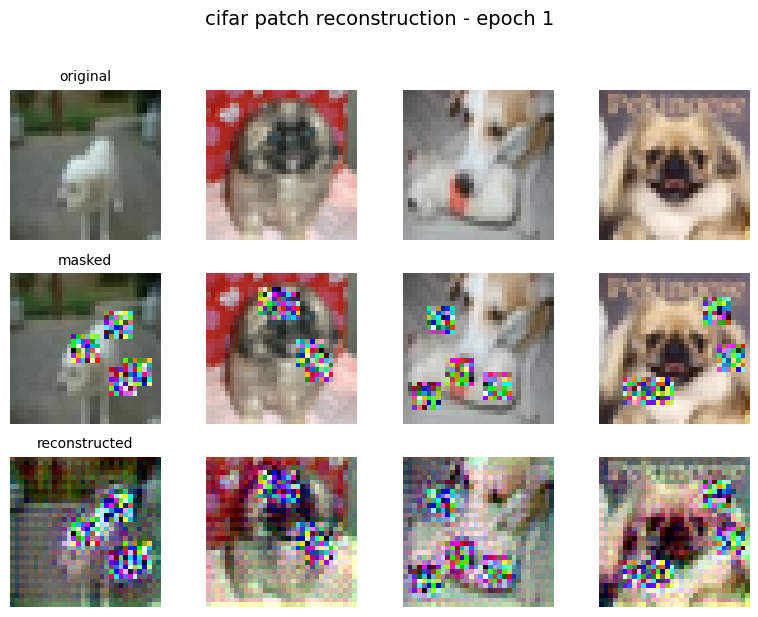

[verbose] models set back to train mode
saved checkpoint at epoch 1 for path=linear, gamma_type=bsquared


KeyboardInterrupt: 

In [57]:
# we define main training setup
if __name__ == "__main__":
    # we set hyperparameters
    base_lr = 1e-4  # we set base learning rate
    batch_size = 32  # we set batch size
    n_epochs = 5000  # we set number of epochs
    patch_size = 6  # we set patch size
    num_patches = 4  # we set number of patches
    metrics_freq = 100  # we set metrics logging frequency
    plot_freq = 500  # we set plotting frequency
    
    print("\nhyperparameters:")  # we print header for hyperparameters
    print(f"  class: dog (cifar10 class 5)")  # we print target class
    print(f"  batch_size: {batch_size}")  # we print batch size
    print(f"  learning_rate: {base_lr}")  # we print base learning rate
    print(f"  n_epochs: {n_epochs}")  # we print number of epochs
    print(f"  patch_size: {patch_size}")  # we print patch size
    print(f"  num_patches: {num_patches}")  # we print number of patches
    
    paths = ["linear", "trig", "encoding-decoding"]  # we define two-sided interpolant paths
    gamma_types = ["bsquared", "sinesquared", "sigmoid"]  # we define non-gaussian gamma schedules
    
    for path in paths:
        for gamma_type in gamma_types:
            print(f"\nusing interpolant: path={path}, gamma_type={gamma_type}")  # we log current interpolant config
            
            interpolant = stochastic_interpolant.Interpolant(path=path, gamma_type=gamma_type)  # we create interpolant
            interpolant.gamma_type = gamma_type  # we store gamma type on interpolant for logging
            
            # we define loss functions for two-sided stochastic interpolant
            loss_fn_b = stochastic_interpolant.make_loss(
                method="shared", interpolant=interpolant, loss_type="b"
            )
            loss_fn_eta = stochastic_interpolant.make_loss(
                method="shared", interpolant=interpolant, loss_type="eta"
            )
            
            # we create networks
            print("\ncreating u-net architectures...")  # we notify network instantiation
            unet_b = UNetDenoiser(in_channels=3, out_channels=3, base_channels=64)  # we create time-conditioned unet for b
            unet_eta = UNetDenoiser(in_channels=3, out_channels=3, base_channels=64)  # we create time-conditioned unet for eta
            
            b = VelocityNetwork(unet_b).to(itf.util.get_torch_device())  # we move b network to device
            eta = EtaNetwork(unet_eta).to(itf.util.get_torch_device())  # we move eta network to device
            
            # we count parameters
            n_params_b = sum(p.numel() for p in b.parameters() if p.requires_grad)  # we count trainable params of b
            n_params_eta = sum(p.numel() for p in eta.parameters() if p.requires_grad)  # we count trainable params of eta
            print(f"b network parameters: {n_params_b:,}")  # we print number of parameters of b
            print(f"eta network parameters: {n_params_eta:,}")  # we print number of parameters of eta
            
            # we create optimizers and schedulers
            opt_b = torch.optim.Adam(b.parameters(), lr=base_lr)  # we create optimizer for b
            opt_eta = torch.optim.Adam(eta.parameters(), lr=base_lr)  # we create optimizer for eta
            sched_b = torch.optim.lr_scheduler.CosineAnnealingLR(
                opt_b, T_max=n_epochs, eta_min=base_lr * 0.01
            )  # we create lr scheduler for b
            sched_eta = torch.optim.lr_scheduler.CosineAnnealingLR(
                opt_eta, T_max=n_epochs, eta_min=base_lr * 0.01
            )  # we create lr scheduler for eta
            
            # we initialize data dictionary
            data_dict = {
                "losses": [],
                "b_losses": [],
                "eta_losses": [],
                "b_grads": [],
                "eta_grads": [],
                "lrs": [],
            }  # we store training metrics
            
            # we train the model for this configuration
            print("\nstarting training...\n")  # we announce training start
            counter = 1  # we initialize iteration counter
            for epoch in range(n_epochs):
                loss, b_loss, eta_loss, b_grad, eta_grad = train_step(
                    batch_size, interpolant, opt_b, opt_eta, sched_b, sched_eta, patch_size, num_patches
                )  # we perform one training step
                
                # we log metrics
                if (counter - 1) % metrics_freq == 0:
                    data_dict["losses"].append(grab(loss).item())  # we log total loss
                    data_dict["b_losses"].append(grab(b_loss).item())  # we log b loss
                    data_dict["eta_losses"].append(grab(eta_loss).item())  # we log eta loss
                    data_dict["b_grads"].append(grab(b_grad).item())  # we log gradient norm of b
                    data_dict["eta_grads"].append(grab(eta_grad).item())  # we log gradient norm of eta
                    data_dict["lrs"].append(opt_b.param_groups[0]["lr"])  # we log learning rate
                    
                    print(
                        f"[path={path} | gamma_type={gamma_type}] epoch {counter}: "
                        f"loss={grab(loss).item():.4f}, "
                        f"b_loss={grab(b_loss).item():.4f}, "
                        f"eta_loss={grab(eta_loss).item():.4f}"
                    )  # we print training status
                
                # we make plots and save checkpoints
                if (counter - 1) % plot_freq == 0:
                    make_plots(
                        b, eta, interpolant, counter, data_dict, patch_size, num_patches,
                        n_params_b=n_params_b, n_params_eta=n_params_eta,
                        image_size=(32, 32), batch_size=batch_size, base_lr=base_lr,
                        metrics_freq=metrics_freq, dataset_name=DATASET_NAME,
                        epsilon_tag=EPSILON_TAG
                    )  # we visualize results with all parameters
                    
                    dataset_tag = f"{DATASET_NAME}_patch{patch_size}x{patch_size}_np{num_patches}_{EPSILON_TAG}"
                    ckpt_dir = os.path.join(RESULTS_ROOT, dataset_tag, "checkpoints")  # we define directory for checkpoints
                    os.makedirs(ckpt_dir, exist_ok=True)  # we ensure checkpoint directory exists
                    ckpt_name = os.path.join(
                        ckpt_dir,
                        f"cifar_checkpoint_{path}_{gamma_type}_epoch_{counter}.pt",
                    )  # we build checkpoint filename
                    torch.save(
                        {
                            "epoch": counter,
                            "b_state_dict": b.state_dict(),
                            "eta_state_dict": eta.state_dict(),
                            "opt_b_state_dict": opt_b.state_dict(),
                            "opt_eta_state_dict": opt_eta.state_dict(),
                            "data_dict": data_dict,
                            "class": "dog",
                            "class_id": 5,
                            "path": path,
                            "gamma_type": gamma_type,
                        },
                        ckpt_name,
                    )  # we save checkpoint
                    print(
                        f"saved checkpoint at epoch {counter} for path={path}, gamma_type={gamma_type}"
                    )  # we log checkpoint saving
                
                counter += 1  # we increment iteration counter
            
            print(f"\ntraining complete for path={path}, gamma_type={gamma_type}\n")  # we mark configuration as finished